In [18]:
#!pip install seaborn
#!pip install openpyxl
#!pip install pmdarima

In [19]:

import pandas as pd
import numpy as np
import random as rd
import time
import csv
import seaborn as sbs
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import train_test_split ,GridSearchCV
import tensorflow as tf
from tensorflow import keras
from matplotlib import pyplot
from pmdarima.arima import auto_arima
from pmdarima.arima import StepwiseContext
import pmdarima as pm
from pmdarima.arima.stationarity import ADFTest
from pmdarima.arima.utils import ndiffs
from sklearn.metrics import mean_squared_error
from sklearn.metrics import median_absolute_error


In [20]:
# fix random seed for reproducibility
tf.random.set_seed(9)

In [21]:
# #from google.colab import drive
#drive.mount('/content/drive')
file_data = 'SN_m_tot_V2.0.csv'
path_name='../datasets/'
path_name_results='../results/'
file_result = 'Result_ARIMA_sunspot.csv'

In [22]:

dataset = pd.read_csv(f'{path_name}{file_data}', sep =';', encoding = 'latin1', decimal='.',usecols=[2,3])
dataset.columns = ['date','num_observations']
dataset.head()
#dataset = pd.read_csv(f'{path_name}{file_data}', sep =';', encoding = 'latin1', decimal='.')
#dataset.columns = ['year','month', 'date','total_sunspot_number','std_derivation','num_observations','def_prov_indicator']
#dataset.head()



,date,num_observations
0,1749.123,104.3
1,1749.204,116.7
2,1749.288,92.8
3,1749.371,141.7
4,1749.455,139.2


In [23]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3295 entries, 0 to 3294
Data columns (total 2 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   date              3295 non-null   float64
 1   num_observations  3295 non-null   float64
dtypes: float64(2)
memory usage: 51.6 KB


In [24]:
#verifica se existe variáveis nulas 
dataset.isna().sum()

date                0
num_observations    0
dtype: int64

In [25]:
def salvar_resultado(nm_dataset, ds_best_param, n_time_steps, MSE, RMSE, MAE, MAPE, sMAPE, Duration):
  #Script to write training cycle results
  data = [nm_dataset, ds_best_param, n_time_steps, MSE, RMSE, MAE, MAPE, sMAPE, Duration]
  fields = ['Dataset','Best Params','n_time_steps','MSE', 'RMSE', 'MAE', 'MAPE','sMAPE','Duration']
  with open(f'{path_name_results}{file_result}', "a",newline='') as csv_file:
    writer = csv.writer(csv_file,delimiter=';')
    writer.writerow(data)  
  print(fields)
  print(data)
    
#Script to create the results file
def criar_arquivo_resultado():
  fields = ['Dataset','Best Params','n_time_steps','MSE', 'RMSE', 'MAE','MAPE','sMAPE','Duration']
  with open(f'{path_name_results}{file_result}', "w",newline='') as csv_file:
    writer = csv.writer(csv_file,delimiter=';')
    writer.writerow(fields)    

In [26]:
# convert an array of values into a dataset matrix
def create_matrix_dataset(dataset, n_time_steps=1):
 #transformação da série => janela deslizande com n_time_steps passo de tempo    
 #tratando o dataframe
 df = pd.DataFrame()
 df['date']=dataset['date']
 df['vl_0']=dataset['num_observations']

 #n_time_steps=12
 for n_step in range(1,n_time_steps+1,1):   
   df['vl_' + str(n_step)] = dataset['num_observations'].shift(n_step)
 df.dropna(inplace=True)
 return np.array(df.drop(columns=['date','vl_0'])), np.array(df['vl_0'])

# convert dataset values into a dataset matrix
def create_dataset(dataset, n_time_steps=1):
 #transformação da série => janela deslizande com n_time_steps passo de tempo    
 #tratando o dataframe
 df = pd.DataFrame()
 df['date']=dataset['date']
 df['vl_0']=dataset['num_observations']

 #n_time_steps=12
 for n_step in range(1,n_time_steps+1,1):   
   df['vl_' + str(n_step)] = dataset['num_observations'].shift(n_step)
 df.dropna(inplace=True)
 return df

In [27]:
  
def save_model(model,n_time_steps):
  # serialize model to JSON
  model_json = model.to_json()
  with open(f'{path_name_results}model_{n_time_steps}.json', "w") as json_file:
    json_file.write(model_json)

  # serialize weights to HDF5
  model.save_weights(f'{path_name_results}model_{n_time_steps}.h5')
  print("Saved model to disk")


In [28]:
def gera_resultado(y_test, predict,nm_dataset, resultado, n_time_steps, Duracao):
 #Mean Squared Error (Mean Squared Difference Between Estimated Values and Actual Values) - MSE
 MSE = mean_squared_error(y_test, predict)    
 #Square Root of Mean Error - RMSE
 RMSE = np.sqrt(mean_squared_error(y_test, predict))    
 #Mean Absolute Distance or Mean Absolute Error - MAE
 MAE= median_absolute_error(y_pred=predict, y_true = y_test) 
  
 #Calculate the MAPE (Mean Absolute Percentage Error)
 MAPE = ((np.mean(np.abs(y_test -predict) / (y_test)))) * 100   
  
 sMAPE = round(
 	np.mean(
 		np.abs(predict - y_test) /
 		((np.abs(predict) + np.abs(y_test)))
 	)*100, 2
 ) 
 salvar_resultado(nm_dataset, resultado, n_time_steps, MSE, RMSE, MAE, MAPE, sMAPE, Duracao)
 return MAPE

array([<AxesSubplot:xlabel='date'>], dtype=object)

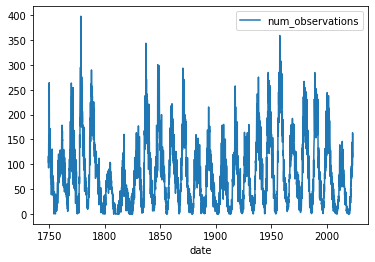

In [29]:
# indexing timestamp
dataset.set_index('date').plot(subplots=True)

In [30]:
def previsao_ARIMA(nm_dataset, dataset, n_time_steps, max_iter): 
    
 #Split dataset in treinam /  80% treinam  20% test
 nlinhas = int(len(dataset) * 0.80)
 test = dataset.iloc[nlinhas:len(dataset),:]  
 train = dataset.iloc[0:nlinhas,:] 
 #  reshape into X=t and Y=t+1 ot n_time_steps by steps
 X_train, Y_train = create_matrix_dataset(train, n_time_steps)
 X_test, Y_test = create_matrix_dataset(test, n_time_steps)  

 # indexing timeserires
 ts_df=create_dataset(dataset, n_time_steps)
 ts_df.set_index('date').plot(subplots=True) 

 Y_train = Y_train.reshape(-1,1)
 Y_test=Y_test.reshape(-1,1) 

 # Armazena a hora de início da execução do Treinamento
 Hora_Inicio = time.time() 

 # Estimate the differences number using ADF test
 # significance level alpha=0.05
 ADF_test = ADFTest(alpha=0.05)
 p_val, should_diff = ADF_test.should_diff(Y_train)   

 if(should_diff):  # if  should_diff is true 
     d = ndiffs(Y_train, test='adf') 
 else: # if  should_diff is False
     d=0 

 # autocorrelation test
 pm.plot_acf(Y_train) 

 # Search for best ARIMA hiperparams.
 with StepwiseContext(max_dur=50):
    model = auto_arima(Y_train, X = X_train,
                       seasonal=True, m=12, maxiter=500, d=0, 
                       start_p=0, start_q=0, max_p=9, max_q=9, 
                       D=None, stepwise=True, trace=True, error_action='ignore', suppress_warnings=True) 

 #print(model.params)
 model.fit(Y_train)
 resultado = model 

 # predictiong values
 predict=model.predict(n_periods=Y_test.shape[0], X=X_test, alpha=0.05)
 predict=predict.reshape(-1,1) 

 Hora_Fim = time.time()    
 

 #print real x predict
 df_predict = pd.DataFrame(predict)
 new_df=pd.DataFrame()
 total=nlinhas+len(df_predict)
 new_df['real']=(dataset.iloc[0:total,1])
 new_df['date']=dataset.iloc[0:total,0]
 new_df['predict']=pd.concat([dataset.iloc[0:nlinhas,1],df_predict],ignore_index=True)
 new_df.set_index('date').plot() 

 #Calculate the duration of the training execution
 Duracao = Hora_Fim - Hora_Inicio    

 #calc metrics of error and save in file
 gera_resultado(Y_test, predict,nm_dataset, resultado, n_time_steps, Duracao)

forecast for new sunspot number


c:\Python\lib\site-packages\pmdarima\utils\visualization.py:220: FutureWarning: the 'unbiased'' keyword is deprecated, use 'adjusted' instead.
  res = tsaplots.plot_acf(


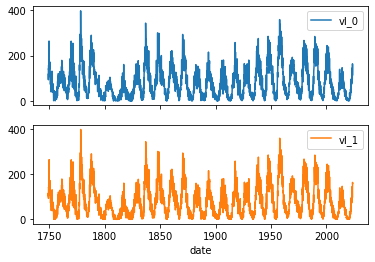

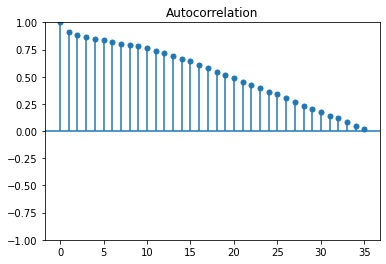

Performing stepwise search to minimize aic
 ARIMA(0,0,0)(1,0,1)[12] intercept   : AIC=24920.550, Time=12.42 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : AIC=24930.089, Time=0.75 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : AIC=24725.822, Time=4.21 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : AIC=24602.786, Time=4.60 sec
 ARIMA(0,0,0)(0,0,0)[12]             : AIC=24997.365, Time=0.86 sec
 ARIMA(0,0,1)(0,0,0)[12] intercept   : AIC=24606.160, Time=1.78 sec
 ARIMA(0,0,1)(1,0,1)[12] intercept   : AIC=24604.706, Time=7.28 sec
 ARIMA(0,0,1)(0,0,2)[12] intercept   : AIC=24603.512, Time=19.30 sec
 ARIMA(0,0,1)(1,0,0)[12] intercept   : AIC=24603.044, Time=4.53 sec
 ARIMA(0,0,1)(1,0,2)[12] intercept   : AIC=inf, Time=31.67 sec
 ARIMA(0,0,0)(0,0,1)[12] intercept   : AIC=24926.084, Time=4.23 sec
 ARIMA(1,0,1)(0,0,1)[12] intercept   : AIC=24566.945, Time=6.81 sec

Best model:  ARIMA(1,0,1)(0,0,1)[12] intercept
Total fit time: 98.507 seconds


c:\Python\lib\site-packages\pmdarima\arima\_auto_solvers.py:324: UserWarning: early termination of stepwise search due to max_dur threshold (98.474 > 50.000)
  warnings.warn('early termination of stepwise search due to '
C:\Users\Edmilson\AppData\Local\Temp\ipykernel_22916\4113161754.py:10: RuntimeWarning: divide by zero encountered in true_divide
  MAPE = ((np.mean(np.abs(y_test -predict) / (y_test)))) * 100
c:\Python\lib\site-packages\pmdarima\utils\visualization.py:220: FutureWarning: the 'unbiased'' keyword is deprecated, use 'adjusted' instead.
  res = tsaplots.plot_acf(


['Dataset', 'Best Params', 'n_time_steps', 'MSE', 'RMSE', 'MAE', 'MAPE', 'sMAPE', 'Duration']
['sunspot', ARIMA(maxiter=500, order=(1, 0, 1), scoring_args={},
      seasonal_order=(0, 0, 1, 12), suppress_warnings=True), 1, 4624.788346355728, 68.0057964173329, 56.31622678790825, inf, 38.55, 102.87830090522766]


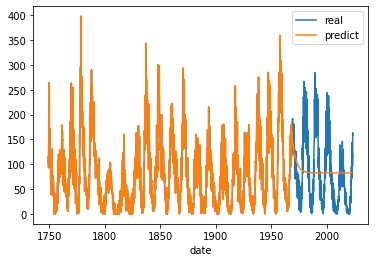

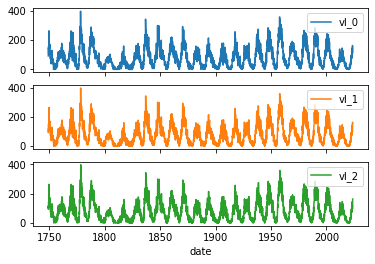

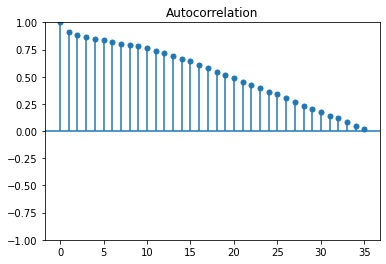

Performing stepwise search to minimize aic
 ARIMA(0,0,0)(1,0,1)[12] intercept   : AIC=24721.274, Time=3.98 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : AIC=24717.790, Time=1.17 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : AIC=24698.160, Time=4.43 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : AIC=24558.440, Time=5.88 sec
 ARIMA(0,0,0)(0,0,0)[12]             : AIC=24754.419, Time=1.50 sec
 ARIMA(0,0,1)(0,0,0)[12] intercept   : AIC=24565.224, Time=1.63 sec
 ARIMA(0,0,1)(1,0,1)[12] intercept   : AIC=24559.217, Time=7.71 sec
 ARIMA(0,0,1)(0,0,2)[12] intercept   : AIC=24558.046, Time=14.77 sec
 ARIMA(0,0,1)(1,0,2)[12] intercept   : AIC=24560.967, Time=30.86 sec
 ARIMA(0,0,0)(0,0,2)[12] intercept   : AIC=24715.544, Time=26.89 sec
 ARIMA(1,0,1)(0,0,2)[12] intercept   : AIC=24558.288, Time=28.41 sec
 ARIMA(0,0,2)(0,0,2)[12] intercept   : AIC=24557.210, Time=41.62 sec

Best model:  ARIMA(0,0,2)(0,0,2)[12] intercept
Total fit time: 168.870 seconds


c:\Python\lib\site-packages\pmdarima\arima\_auto_solvers.py:324: UserWarning: early termination of stepwise search due to max_dur threshold (168.853 > 50.000)
  warnings.warn('early termination of stepwise search due to '
C:\Users\Edmilson\AppData\Local\Temp\ipykernel_22916\4113161754.py:10: RuntimeWarning: divide by zero encountered in true_divide
  MAPE = ((np.mean(np.abs(y_test -predict) / (y_test)))) * 100


['Dataset', 'Best Params', 'n_time_steps', 'MSE', 'RMSE', 'MAE', 'MAPE', 'sMAPE', 'Duration']
['sunspot', ARIMA(maxiter=500, order=(0, 0, 2), scoring_args={},
      seasonal_order=(0, 0, 2, 12), suppress_warnings=True), 2, 4642.294679714798, 68.13438691083084, 54.079526478196186, inf, 38.66, 184.1234745979309]


c:\Python\lib\site-packages\pmdarima\utils\visualization.py:220: FutureWarning: the 'unbiased'' keyword is deprecated, use 'adjusted' instead.
  res = tsaplots.plot_acf(


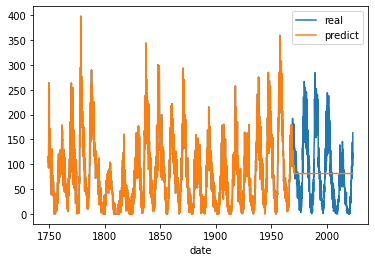

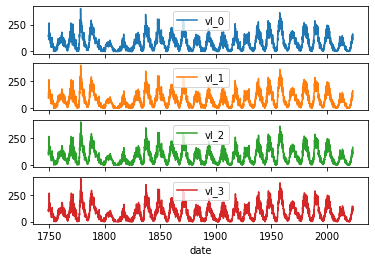

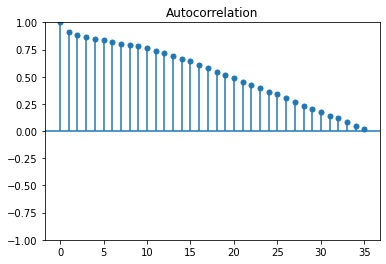

Performing stepwise search to minimize aic
 ARIMA(0,0,0)(1,0,1)[12] intercept   : AIC=24615.680, Time=22.43 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : AIC=24616.710, Time=2.00 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : AIC=24567.207, Time=9.85 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : AIC=24548.233, Time=7.91 sec
 ARIMA(0,0,0)(0,0,0)[12]             : AIC=24640.858, Time=1.12 sec
 ARIMA(0,0,1)(0,0,0)[12] intercept   : AIC=24555.250, Time=2.28 sec
 ARIMA(0,0,1)(1,0,1)[12] intercept   : AIC=24548.669, Time=8.46 sec
 ARIMA(0,0,1)(0,0,2)[12] intercept   : AIC=24547.847, Time=21.60 sec

Best model:  ARIMA(0,0,1)(0,0,2)[12] intercept
Total fit time: 75.690 seconds


c:\Python\lib\site-packages\pmdarima\arima\_auto_solvers.py:324: UserWarning: early termination of stepwise search due to max_dur threshold (75.656 > 50.000)
  warnings.warn('early termination of stepwise search due to '
C:\Users\Edmilson\AppData\Local\Temp\ipykernel_22916\4113161754.py:10: RuntimeWarning: divide by zero encountered in true_divide
  MAPE = ((np.mean(np.abs(y_test -predict) / (y_test)))) * 100


['Dataset', 'Best Params', 'n_time_steps', 'MSE', 'RMSE', 'MAE', 'MAPE', 'sMAPE', 'Duration']
['sunspot', ARIMA(maxiter=500, order=(0, 0, 1), scoring_args={},
      seasonal_order=(0, 0, 2, 12), suppress_warnings=True), 3, 4635.7397965210275, 68.08626731229307, 54.04138180409343, inf, 38.63, 86.6391327381134]


c:\Python\lib\site-packages\pmdarima\utils\visualization.py:220: FutureWarning: the 'unbiased'' keyword is deprecated, use 'adjusted' instead.
  res = tsaplots.plot_acf(


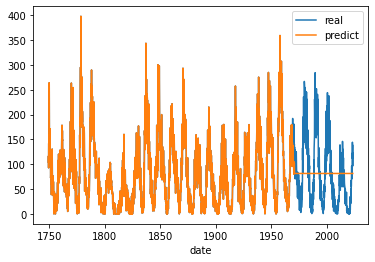

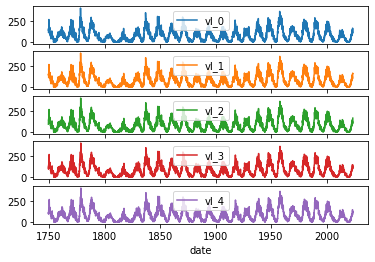

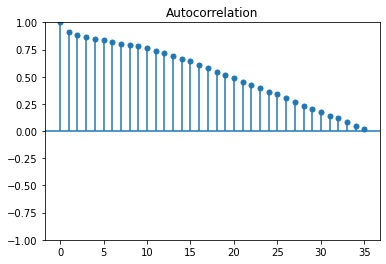

Performing stepwise search to minimize aic
 ARIMA(0,0,0)(1,0,1)[12] intercept   : AIC=24555.179, Time=15.63 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : AIC=24560.124, Time=1.08 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : AIC=24548.249, Time=9.40 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : AIC=24534.096, Time=11.03 sec
 ARIMA(0,0,0)(0,0,0)[12]             : AIC=24577.833, Time=1.51 sec
 ARIMA(0,0,1)(0,0,0)[12] intercept   : AIC=24542.259, Time=3.14 sec
 ARIMA(0,0,1)(1,0,1)[12] intercept   : AIC=24534.463, Time=16.21 sec
 ARIMA(0,0,1)(0,0,2)[12] intercept   : AIC=24533.588, Time=27.93 sec

Best model:  ARIMA(0,0,1)(0,0,2)[12] intercept
Total fit time: 85.950 seconds


c:\Python\lib\site-packages\pmdarima\arima\_auto_solvers.py:324: UserWarning: early termination of stepwise search due to max_dur threshold (85.937 > 50.000)
  warnings.warn('early termination of stepwise search due to '
C:\Users\Edmilson\AppData\Local\Temp\ipykernel_22916\4113161754.py:10: RuntimeWarning: divide by zero encountered in true_divide
  MAPE = ((np.mean(np.abs(y_test -predict) / (y_test)))) * 100


['Dataset', 'Best Params', 'n_time_steps', 'MSE', 'RMSE', 'MAE', 'MAPE', 'sMAPE', 'Duration']
['sunspot', ARIMA(maxiter=500, order=(0, 0, 1), scoring_args={},
      seasonal_order=(0, 0, 2, 12), suppress_warnings=True), 4, 4636.136529497015, 68.0891807080759, 53.94263844820651, inf, 38.66, 95.51510310173035]


c:\Python\lib\site-packages\pmdarima\utils\visualization.py:220: FutureWarning: the 'unbiased'' keyword is deprecated, use 'adjusted' instead.
  res = tsaplots.plot_acf(


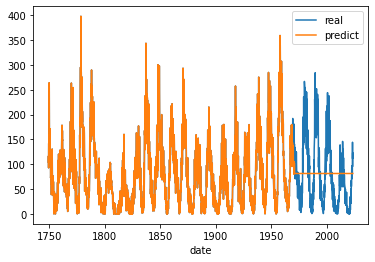

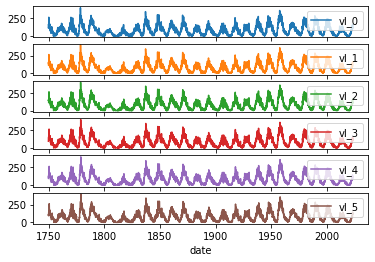

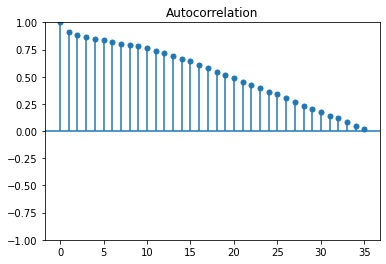

Performing stepwise search to minimize aic
 ARIMA(0,0,0)(1,0,1)[12] intercept   : AIC=24534.153, Time=15.61 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : AIC=24540.358, Time=1.40 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : AIC=24526.732, Time=20.18 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : AIC=24527.540, Time=12.37 sec
 ARIMA(0,0,0)(0,0,0)[12]             : AIC=24555.319, Time=1.43 sec

Best model:  ARIMA(1,0,0)(1,0,0)[12] intercept
Total fit time: 51.007 seconds


c:\Python\lib\site-packages\pmdarima\arima\_auto_solvers.py:324: UserWarning: early termination of stepwise search due to max_dur threshold (50.991 > 50.000)
  warnings.warn('early termination of stepwise search due to '
C:\Users\Edmilson\AppData\Local\Temp\ipykernel_22916\4113161754.py:10: RuntimeWarning: divide by zero encountered in true_divide
  MAPE = ((np.mean(np.abs(y_test -predict) / (y_test)))) * 100


['Dataset', 'Best Params', 'n_time_steps', 'MSE', 'RMSE', 'MAE', 'MAPE', 'sMAPE', 'Duration']
['sunspot', ARIMA(maxiter=500, order=(1, 0, 0), scoring_args={},
      seasonal_order=(1, 0, 0, 12), suppress_warnings=True), 5, 4617.372672547005, 67.951252177918, 53.719179237150826, inf, 38.56, 55.14738583564758]


c:\Python\lib\site-packages\pmdarima\utils\visualization.py:220: FutureWarning: the 'unbiased'' keyword is deprecated, use 'adjusted' instead.
  res = tsaplots.plot_acf(


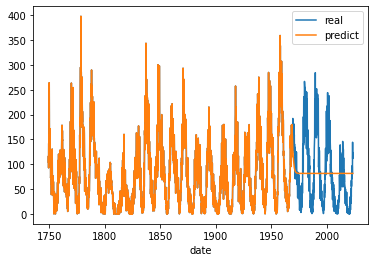

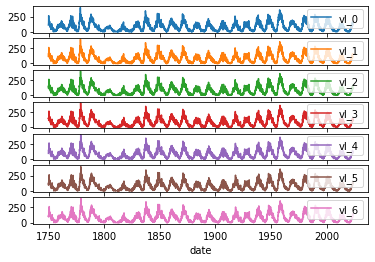

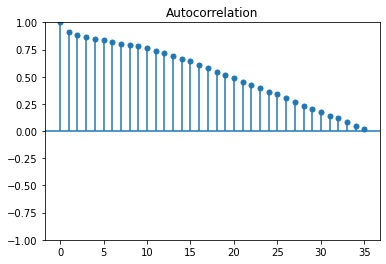

Performing stepwise search to minimize aic
 ARIMA(0,0,0)(1,0,1)[12] intercept   : AIC=24515.970, Time=17.26 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : AIC=24523.623, Time=1.70 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : AIC=24517.746, Time=19.02 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : AIC=24516.902, Time=25.38 sec
 ARIMA(0,0,0)(0,0,0)[12]             : AIC=24536.591, Time=1.81 sec

Best model:  ARIMA(0,0,0)(1,0,1)[12] intercept
Total fit time: 65.191 seconds


c:\Python\lib\site-packages\pmdarima\arima\_auto_solvers.py:324: UserWarning: early termination of stepwise search due to max_dur threshold (65.171 > 50.000)
  warnings.warn('early termination of stepwise search due to '
C:\Users\Edmilson\AppData\Local\Temp\ipykernel_22916\4113161754.py:10: RuntimeWarning: divide by zero encountered in true_divide
  MAPE = ((np.mean(np.abs(y_test -predict) / (y_test)))) * 100


['Dataset', 'Best Params', 'n_time_steps', 'MSE', 'RMSE', 'MAE', 'MAPE', 'sMAPE', 'Duration']
['sunspot', ARIMA(maxiter=500, order=(0, 0, 0), scoring_args={},
      seasonal_order=(1, 0, 1, 12), suppress_warnings=True), 6, 4634.840040606703, 68.07965952181829, 55.44767466922721, inf, 38.66, 70.94050288200378]


c:\Python\lib\site-packages\pmdarima\utils\visualization.py:220: FutureWarning: the 'unbiased'' keyword is deprecated, use 'adjusted' instead.
  res = tsaplots.plot_acf(


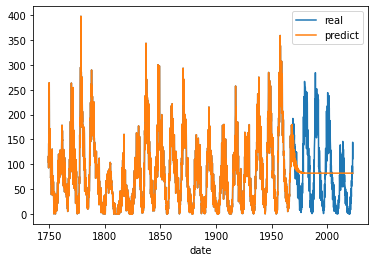

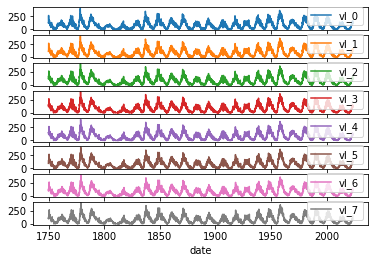

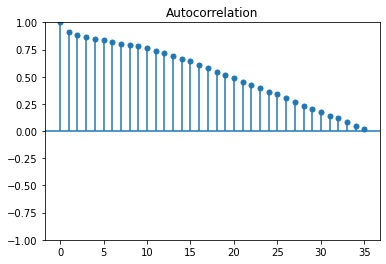

Performing stepwise search to minimize aic
 ARIMA(0,0,0)(1,0,1)[12] intercept   : AIC=24508.104, Time=18.10 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : AIC=24515.595, Time=2.44 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : AIC=24510.212, Time=19.74 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : AIC=24510.480, Time=39.99 sec
 ARIMA(0,0,0)(0,0,0)[12]             : AIC=24528.797, Time=3.10 sec

Best model:  ARIMA(0,0,0)(1,0,1)[12] intercept
Total fit time: 83.410 seconds


c:\Python\lib\site-packages\pmdarima\arima\_auto_solvers.py:324: UserWarning: early termination of stepwise search due to max_dur threshold (83.380 > 50.000)
  warnings.warn('early termination of stepwise search due to '
C:\Users\Edmilson\AppData\Local\Temp\ipykernel_22916\4113161754.py:10: RuntimeWarning: divide by zero encountered in true_divide
  MAPE = ((np.mean(np.abs(y_test -predict) / (y_test)))) * 100


['Dataset', 'Best Params', 'n_time_steps', 'MSE', 'RMSE', 'MAE', 'MAPE', 'sMAPE', 'Duration']
['sunspot', ARIMA(maxiter=500, order=(0, 0, 0), scoring_args={},
      seasonal_order=(1, 0, 1, 12), suppress_warnings=True), 7, 4639.625097810649, 68.11479353129282, 55.64659257405752, inf, 38.73, 89.76031756401062]


c:\Python\lib\site-packages\pmdarima\utils\visualization.py:220: FutureWarning: the 'unbiased'' keyword is deprecated, use 'adjusted' instead.
  res = tsaplots.plot_acf(


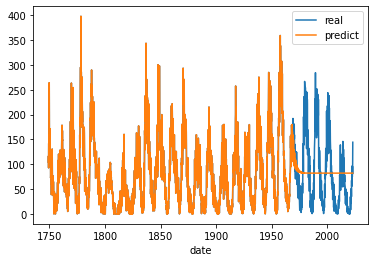

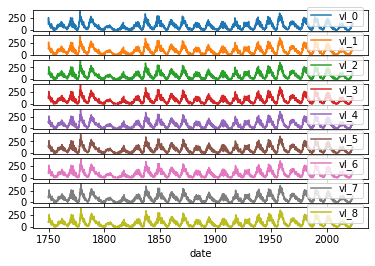

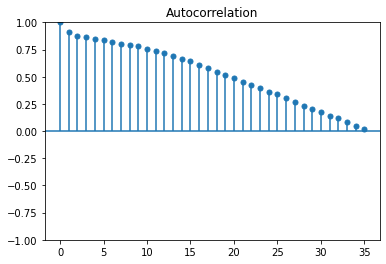

Performing stepwise search to minimize aic
 ARIMA(0,0,0)(1,0,1)[12] intercept   : AIC=24500.634, Time=29.52 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : AIC=24508.524, Time=6.39 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : AIC=24498.372, Time=71.12 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : AIC=24500.962, Time=27.99 sec
 ARIMA(0,0,0)(0,0,0)[12]             : AIC=24521.127, Time=4.78 sec

Best model:  ARIMA(1,0,0)(1,0,0)[12] intercept
Total fit time: 139.848 seconds


c:\Python\lib\site-packages\pmdarima\arima\_auto_solvers.py:324: UserWarning: early termination of stepwise search due to max_dur threshold (139.815 > 50.000)
  warnings.warn('early termination of stepwise search due to '
C:\Users\Edmilson\AppData\Local\Temp\ipykernel_22916\4113161754.py:10: RuntimeWarning: divide by zero encountered in true_divide
  MAPE = ((np.mean(np.abs(y_test -predict) / (y_test)))) * 100


['Dataset', 'Best Params', 'n_time_steps', 'MSE', 'RMSE', 'MAE', 'MAPE', 'sMAPE', 'Duration']
['sunspot', ARIMA(maxiter=500, order=(1, 0, 0), scoring_args={},
      seasonal_order=(1, 0, 0, 12), suppress_warnings=True), 8, 4624.917066465654, 68.00674280147267, 53.88718441953395, inf, 38.65, 149.25015664100647]


c:\Python\lib\site-packages\pmdarima\utils\visualization.py:220: FutureWarning: the 'unbiased'' keyword is deprecated, use 'adjusted' instead.
  res = tsaplots.plot_acf(


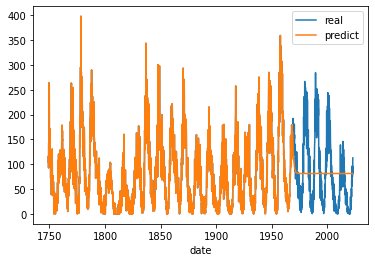

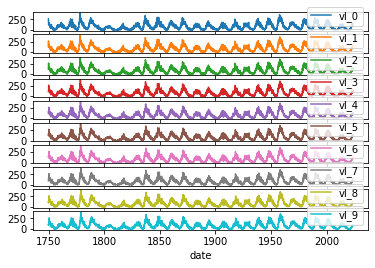

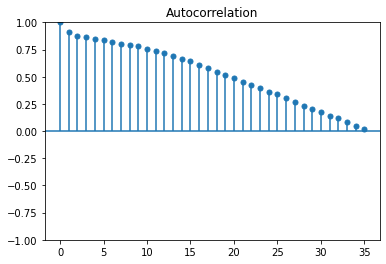

Performing stepwise search to minimize aic
 ARIMA(0,0,0)(1,0,1)[12] intercept   : AIC=24485.471, Time=34.25 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : AIC=24494.698, Time=5.28 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : AIC=24472.210, Time=35.99 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : AIC=24471.503, Time=65.70 sec
 ARIMA(0,0,0)(0,0,0)[12]             : AIC=24505.743, Time=9.80 sec

Best model:  ARIMA(0,0,1)(0,0,1)[12] intercept
Total fit time: 151.057 seconds


c:\Python\lib\site-packages\pmdarima\arima\_auto_solvers.py:324: UserWarning: early termination of stepwise search due to max_dur threshold (151.026 > 50.000)
  warnings.warn('early termination of stepwise search due to '
C:\Users\Edmilson\AppData\Local\Temp\ipykernel_22916\4113161754.py:10: RuntimeWarning: divide by zero encountered in true_divide
  MAPE = ((np.mean(np.abs(y_test -predict) / (y_test)))) * 100


['Dataset', 'Best Params', 'n_time_steps', 'MSE', 'RMSE', 'MAE', 'MAPE', 'sMAPE', 'Duration']
['sunspot', ARIMA(maxiter=500, order=(0, 0, 1), scoring_args={},
      seasonal_order=(0, 0, 1, 12), suppress_warnings=True), 9, 4665.475446082453, 68.30428570801728, 54.150000000000006, inf, 38.94, 160.93807005882263]


c:\Python\lib\site-packages\pmdarima\utils\visualization.py:220: FutureWarning: the 'unbiased'' keyword is deprecated, use 'adjusted' instead.
  res = tsaplots.plot_acf(


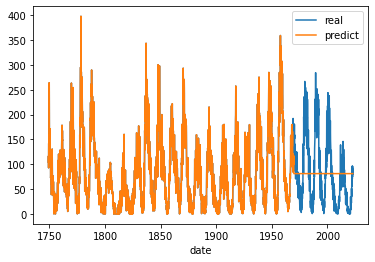

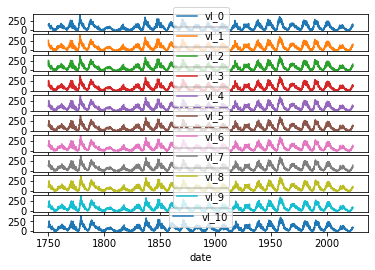

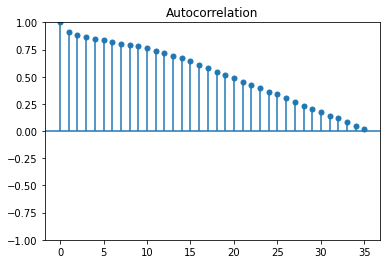

Performing stepwise search to minimize aic
 ARIMA(0,0,0)(1,0,1)[12] intercept   : AIC=24441.066, Time=24.22 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : AIC=24452.203, Time=7.43 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : AIC=24429.777, Time=70.42 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : AIC=24441.877, Time=64.28 sec
 ARIMA(0,0,0)(0,0,0)[12]             : AIC=24464.642, Time=7.27 sec

Best model:  ARIMA(1,0,0)(1,0,0)[12] intercept
Total fit time: 173.709 seconds


c:\Python\lib\site-packages\pmdarima\arima\_auto_solvers.py:324: UserWarning: early termination of stepwise search due to max_dur threshold (173.638 > 50.000)
  warnings.warn('early termination of stepwise search due to '
C:\Users\Edmilson\AppData\Local\Temp\ipykernel_22916\4113161754.py:10: RuntimeWarning: divide by zero encountered in true_divide
  MAPE = ((np.mean(np.abs(y_test -predict) / (y_test)))) * 100


['Dataset', 'Best Params', 'n_time_steps', 'MSE', 'RMSE', 'MAE', 'MAPE', 'sMAPE', 'Duration']
['sunspot', ARIMA(maxiter=500, order=(1, 0, 0), scoring_args={},
      seasonal_order=(1, 0, 0, 12), suppress_warnings=True), 10, 4632.079947046224, 68.05938544422969, 53.90823016234016, inf, 38.73, 185.28786277770996]


c:\Python\lib\site-packages\pmdarima\utils\visualization.py:220: FutureWarning: the 'unbiased'' keyword is deprecated, use 'adjusted' instead.
  res = tsaplots.plot_acf(


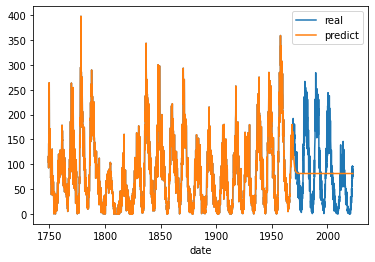

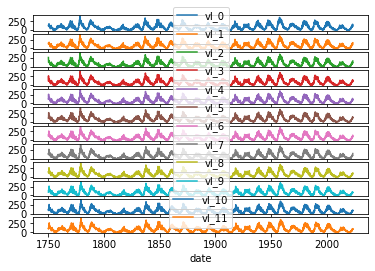

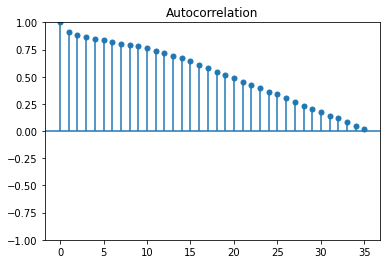

Performing stepwise search to minimize aic
 ARIMA(0,0,0)(1,0,1)[12] intercept   : AIC=24417.300, Time=63.45 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : AIC=24432.976, Time=6.72 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : AIC=24411.603, Time=121.47 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : AIC=24332.498, Time=78.14 sec
 ARIMA(0,0,0)(0,0,0)[12]             : AIC=24446.783, Time=9.15 sec

Best model:  ARIMA(0,0,1)(0,0,1)[12] intercept
Total fit time: 278.983 seconds


c:\Python\lib\site-packages\pmdarima\arima\_auto_solvers.py:324: UserWarning: early termination of stepwise search due to max_dur threshold (278.935 > 50.000)
  warnings.warn('early termination of stepwise search due to '
C:\Users\Edmilson\AppData\Local\Temp\ipykernel_22916\4113161754.py:10: RuntimeWarning: divide by zero encountered in true_divide
  MAPE = ((np.mean(np.abs(y_test -predict) / (y_test)))) * 100


['Dataset', 'Best Params', 'n_time_steps', 'MSE', 'RMSE', 'MAE', 'MAPE', 'sMAPE', 'Duration']
['sunspot', ARIMA(maxiter=500, order=(0, 0, 1), scoring_args={},
      seasonal_order=(0, 0, 1, 12), suppress_warnings=True), 11, 4673.666373369888, 68.3642185164863, 53.75000000000001, inf, 38.98, 288.2929263114929]


c:\Python\lib\site-packages\pmdarima\utils\visualization.py:220: FutureWarning: the 'unbiased'' keyword is deprecated, use 'adjusted' instead.
  res = tsaplots.plot_acf(


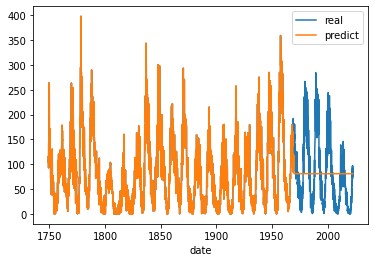

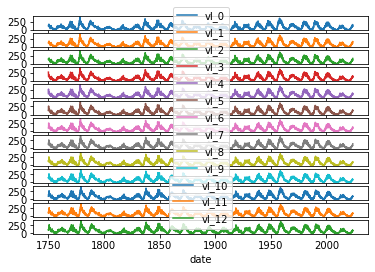

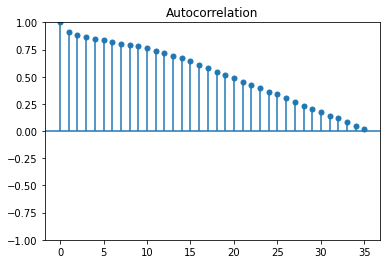

Performing stepwise search to minimize aic
 ARIMA(0,0,0)(1,0,1)[12] intercept   : AIC=24378.904, Time=62.54 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : AIC=24417.377, Time=11.57 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : AIC=24382.104, Time=66.90 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : AIC=24372.432, Time=65.00 sec
 ARIMA(0,0,0)(0,0,0)[12]             : AIC=24432.928, Time=12.67 sec

Best model:  ARIMA(0,0,1)(0,0,1)[12] intercept
Total fit time: 218.726 seconds


c:\Python\lib\site-packages\pmdarima\arima\_auto_solvers.py:324: UserWarning: early termination of stepwise search due to max_dur threshold (218.695 > 50.000)
  warnings.warn('early termination of stepwise search due to '
C:\Users\Edmilson\AppData\Local\Temp\ipykernel_22916\4113161754.py:10: RuntimeWarning: divide by zero encountered in true_divide
  MAPE = ((np.mean(np.abs(y_test -predict) / (y_test)))) * 100


['Dataset', 'Best Params', 'n_time_steps', 'MSE', 'RMSE', 'MAE', 'MAPE', 'sMAPE', 'Duration']
['sunspot', ARIMA(maxiter=500, order=(0, 0, 1), scoring_args={},
      seasonal_order=(0, 0, 1, 12), suppress_warnings=True), 12, 4673.893716529145, 68.36588123127753, 54.03412177636375, inf, 39.0, 228.72605538368225]


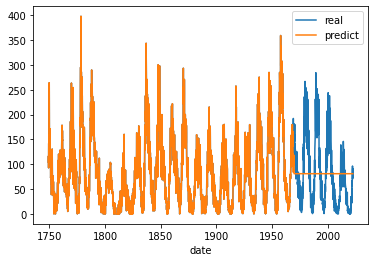

In [31]:
#create file to results
criar_arquivo_resultado()

print('forecast for new sunspot number')
max_iter =500 # number of epochs for train


for n_time_steps in range(1,13): #predict with 1 to 12 past values of medition 
   previsao_ARIMA('sunspot', dataset, n_time_steps, max_iter)